In [1]:
import os
from pyprojroot import here

os.environ["TRANSFORMERS_CACHE"] = str(here("cache/transformers"))

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model

c:\Users\Plancha\Desktop\AML-homework\.pixi\envs\gpu\Lib\site-packages\transformers\utils\hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [2]:
# test one example
model.eval()
# Add padding token if not already present
tokenizer.add_special_tokens({"pad_token": "<|pad|>"})
model.resize_token_embeddings(len(tokenizer))

# Generate text
prompt = "The future of artificial intelligence is"
inputs = tokenizer(prompt, return_tensors="pt")

# Generate with different parameters
with torch.no_grad():
  outputs = model.generate(
    inputs.input_ids,
    max_new_tokens=100,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    do_sample=True,
    temperature=0.7,
  )

# Decode and display
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


The future of artificial intelligence is bright. But as the world gets more complex and more sophisticated, the technology will become more complex.

"I really hope that this is not just a technical issue. It is something we will have to look at," the CTO said.


In [3]:
# dataset from https://recipenlg.cs.put.poznan.pl/
import pandas as pd
import duckdb as sql

data = sql.query(f"""
  select title, directions
  from read_csv(
    '{here("data/recipeNLG/recipeNLG.csv")}', 
    header=True,
    delim=',',
    types = {{
      'title': 'VARCHAR',
      'ingredients': 'VARCHAR[]',
      "directions": 'VARCHAR[]'
    }}
  )
  limit 1000
""")
data = data.df()
data

,title,directions
0,No-Bake Nut Cookies,"[In a heavy 2-quart saucepan, mix brown sugar,..."
1,Jewell Ball'S Chicken,"[Place chipped beef on bottom of baking dish.,..."
2,Creamy Corn,"[In a slow cooker, combine all ingredients. Co..."
3,Chicken Funny,"[Boil and debone chicken., Put bite size piece..."
4,Reeses Cups(Candy),[Combine first four ingredients and press in 1...
...,...,...
995,Heath Bar Pie,[Mix chopped Heath bars with whipped topping a...
996,Victorian Baked French Toast,"[Cook brown sugar, butter and corn syrup in sm..."
997,Quick Swedish Meatballs,"[Combine meat, bread crumbs, cheese, soup mix,..."
998,Irish Stew(Microwave),"[In 4-quart casserole, combine lamb, 1 1/4 cup..."


In [4]:
from tqdm.notebook import tqdm

tqdm.pandas(desc="Formatting directions")

# in directions, transform list to string, with every line starting with "1 -"
data["directions"] = data["directions"].progress_apply(
  lambda x: "\n".join([f"{i + 1} - {step}" for i, step in enumerate(x)])
)
data["formatted"] = data.progress_apply(
  lambda row: f"Recipe: {row['title']}\n\nInstructions:\n{row['directions']}\n{tokenizer.eos_token}",
  axis=1,
)
data

Formatting directions:   0%|          | 0/1000 [00:00<?, ?it/s]

Formatting directions:   0%|          | 0/1000 [00:00<?, ?it/s]

,title,directions,formatted
0,No-Bake Nut Cookies,"1 - In a heavy 2-quart saucepan, mix brown sug...",Recipe: No-Bake Nut Cookies\n\nInstructions:\n...
1,Jewell Ball'S Chicken,1 - Place chipped beef on bottom of baking dis...,Recipe: Jewell Ball'S Chicken\n\nInstructions:...
2,Creamy Corn,"1 - In a slow cooker, combine all ingredients....",Recipe: Creamy Corn\n\nInstructions:\n1 - In a...
3,Chicken Funny,1 - Boil and debone chicken.\n2 - Put bite siz...,Recipe: Chicken Funny\n\nInstructions:\n1 - Bo...
4,Reeses Cups(Candy),1 - Combine first four ingredients and press i...,Recipe: Reeses Cups(Candy) \n\nInstructions:\...
...,...,...,...
995,Heath Bar Pie,1 - Mix chopped Heath bars with whipped toppin...,Recipe: Heath Bar Pie\n\nInstructions:\n1 - Mi...
996,Victorian Baked French Toast,"1 - Cook brown sugar, butter and corn syrup in...",Recipe: Victorian Baked French Toast\n\nInstru...
997,Quick Swedish Meatballs,"1 - Combine meat, bread crumbs, cheese, soup m...",Recipe: Quick Swedish Meatballs\n\nInstruction...
998,Irish Stew(Microwave),"1 - In 4-quart casserole, combine lamb, 1 1/4 ...",Recipe: Irish Stew(Microwave) \n\nInstruction...


In [5]:
print(data["formatted"][0])

Recipe: No-Bake Nut Cookies

Instructions:
1 - In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.
2 - Stir over medium heat until mixture bubbles all over top.
3 - Boil and stir 5 minutes more. Take off heat.
4 - Stir in vanilla and cereal; mix well.
5 - Using 2 teaspoons, drop and shape into 30 clusters on wax paper.
6 - Let stand until firm, about 30 minutes.
<|endoftext|>


In [6]:
from torch.utils.data import Dataset


# Custom Dataset class
class RecipeDataset(Dataset):
  def __init__(self, texts, tokenizer, max_length=512):
    self.texts = texts
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    encoding = self.tokenizer(
      text,
      truncation=True,
      padding="max_length",
      max_length=self.max_length,
      return_tensors="pt",
    )

    return {
      "input_ids": encoding["input_ids"].flatten(),
      "attention_mask": encoding["attention_mask"].flatten(),
    }


dataset = RecipeDataset(
  texts=data["formatted"].tolist(), tokenizer=tokenizer, max_length=512
)

In [7]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
  output_dir=str(here("models/gpt2-recipe-finetuned")),
  overwrite_output_dir=True,
  num_train_epochs=4,
)

data_collator = DataCollatorForLanguageModeling(
  tokenizer=tokenizer,
  mlm=False,  # GPT-2 is not a masked language model
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=dataset,
  data_collator=data_collator,
  tokenizer=tokenizer,
)

print("Trainer initialized")
print(
  f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

C:\Users\Plancha\AppData\Local\Temp\ipykernel_29048\3010357902.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer initialized
Number of trainable parameters: 124,440,576


In [8]:
from pathlib import Path

model_save_path = here("models/gpt2-recipe-finetuned")
if Path(model_save_path).exists():
  print("Loading existing fine-tuned model...")
  model = AutoModelForCausalLM.from_pretrained(model_save_path)
  tokenizer = AutoTokenizer.from_pretrained(model_save_path)
else:
  # Start fine-tuning
  print("Starting fine-tuning...")
  trainer.train()

  # Save the fine-tuned model
  trainer.save_model(model_save_path)
  tokenizer.save_pretrained(model_save_path)
  print(f"Fine-tuned model saved to: {model_save_path}")

Loading existing fine-tuned model...


In [9]:
# Test the fine-tuned model
eval_data = sql.query(f"""
  select title, directions
  from read_csv(
    '{here("data/recipeNLG/recipeNLG.csv")}', 
    header=True,
    delim=',',
    types = {{
      'title': 'VARCHAR',
      'ingredients': 'VARCHAR[]',
      "directions": 'VARCHAR[]'
    }}
  )
  limit 5
  offset 1001
""")
eval_data = eval_data.df()
eval_data["directions"] = eval_data["directions"].progress_apply(
  lambda x: "\n".join([f"{i + 1} - {step}" for i, step in enumerate(x)])
)
eval_data["formatted"] = eval_data.progress_apply(
  lambda row: f"Recipe: {row['title']}\n\nInstructions:\n{row['directions']}\n{tokenizer.eos_token}",
  axis=1,
)
eval_dataset = RecipeDataset(
  texts=eval_data["formatted"].tolist(), tokenizer=tokenizer, max_length=512
)
for i in eval_data["formatted"]:
  print(i)
  print("----")
  print("----")

Formatting directions:   0%|          | 0/5 [00:00<?, ?it/s]

Formatting directions:   0%|          | 0/5 [00:00<?, ?it/s]

Recipe: Pepperoni Loaf

Instructions:
1 - Take thawed bread and roll out onto cookie sheet.
2 - Set on door of oven preheated to 350u00b0 and let it rise for 15 to 20 minutes (until puffy).
3 - Lay the slices of Provolone over entire loaf and then layer the pepperoni slices.
4 - Roll bread in a jelly-like roll. Take egg white and baste bread.
5 - Sprinkle sesame seed on top. Bake at 350u00b0 for 30 minutes.
<|endoftext|>
----
----
Recipe: Animal Crackers

Instructions:
1 - Grind oatmeal in blender until fine.
2 - Add honey, salt, flour and soda.
3 - Stir. Cut in butter. Add buttermilk and stir.
4 - Roll very thin.
5 - Cut with animal cookie cutters.
6 - Bake at 400u00b0 until brown (10 to 12 minutes).
<|endoftext|>
----
----
Recipe: Sauerkraut

Instructions:
1 - Cook kraut and water about 10 minutes.
2 - Fry bacon.
3 - Add onion to
4 - drippings and cook until onion is glazed.
5 - Add flour and stir well.
6 - Pour
7 - water from kraut into gravy mixture and add sugar. Add kraut.
8 - Sa

In [35]:
def generate_text(model, tokenizer, prompt, device, max_new_tokens=1024, temperature=1):
  """Generate text using a given model and tokenizer."""
  model.eval()
  inputs = tokenizer(prompt, return_tensors="pt")
  inputs = {k: v.to(device) for k, v in inputs.items()}

  with torch.no_grad():
    outputs = model.generate(
      inputs["input_ids"],
      max_new_tokens=max_new_tokens,
      eos_token_id=tokenizer.eos_token_id,
      pad_token_id=tokenizer.pad_token_id,
      do_sample=True,
      temperature=temperature,
    )

  return tokenizer.decode(outputs[0], skip_special_tokens=False)


def compare_models(fine_tuned_model, original_model, tokenizer, prompt, device):
  """Compare outputs from fine-tuned and original models."""
  print(f"Input: {prompt}")
  print("=" * 50)

  # Fine-tuned model generation
  print("FINE-TUNED MODEL OUTPUT:")
  fine_tuned_output = generate_text(
    fine_tuned_model, tokenizer, prompt, device, max_new_tokens=1024
  )
  print(fine_tuned_output)
  print("-" * 50)

  # Original model generation
  print("ORIGINAL MODEL OUTPUT:")
  original_output = generate_text(
    original_model, tokenizer, prompt, device, max_new_tokens=100
  )
  print(original_output)
  print("=" * 50)
  print()


"\n".join(eval_data["formatted"][0].split("\n")[:3])

'Recipe: Pepperoni Loaf\n\nInstructions:'

In [37]:
# Generate text using the fine-tuned model
device = next(model.parameters()).device
prompt = "\n".join(eval_data["formatted"][0].split("\n")[:3])
print(generate_text(model, tokenizer, prompt, device, max_new_tokens=1024))

Recipe: Pepperoni Loaf

Instructions:
1 - Layer beef bouillon in a loaf pan.
2 - Set aside to cool.
3 - Cut shortening in order:
4 - (1/4 - bouillon; 1/4 c butter.)
5 - Combine flour, sugar and salt.
6 - Mix well.
7 - Add remaining ingredients according to package directions and chill.
8 - Combine flour mixture, sugar syrup and salt.
9 - Combine remaining ingredients according to package directions and chill.
10 - When done, layer on cheese.
11 - Bake at 350u00b0 for 15 to 20 minutes or until bubbly.
<|endoftext|>


In [38]:
# Generate text using the original model
original_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
original_model.eval()
original_model.to(device)
prompt = "\n".join(eval_data["formatted"][0].split("\n")[:3])
print(generate_text(original_model, tokenizer, prompt, device, max_new_tokens=100))

Recipe: Pepperoni Loaf

Instructions:

In a mixing bowl, whisk together cream cheese, tomatoes, pepperoni and Italian seasoning. Add tomato paste mixture to a blender and mix until smooth (about 11 minutes). In another bowl, combine egg, salt and pepper, and stir with electric hand mixer until smooth. Pour in Parmesan cheese, tomatoes and Parmesan. Bake for 50 minutes.

Serving Size:

7 ounces

*Note: This recipe does not require a prepackaged serving or recipe.


In [ ]:
# Compare with other examples
for i in eval_data["formatted"]:
  print(i)
  print("----")
  compare_models(model, original_model, tokenizer, "\n".join(i.split("\n")[:3]), device)
  print("----")

Recipe: Pepperoni Loaf

Instructions:
1 - Take thawed bread and roll out onto cookie sheet.
2 - Set on door of oven preheated to 350u00b0 and let it rise for 15 to 20 minutes (until puffy).
3 - Lay the slices of Provolone over entire loaf and then layer the pepperoni slices.
4 - Roll bread in a jelly-like roll. Take egg white and baste bread.
5 - Sprinkle sesame seed on top. Bake at 350u00b0 for 30 minutes.
<|endoftext|>
----
Input: Recipe: Pepperoni Loaf

Instructions:
FINE-TUNED MODEL OUTPUT:
Recipe: Pepperoni Loaf

Instructions:
1 - Bake in 400u00b0 oven until firm at 400u00b0.
2 - You can also brown peppers in oven.
<|endoftext|>
--------------------------------------------------
ORIGINAL MODEL OUTPUT:
Recipe: Pepperoni Loaf

Instructions:
1 - Bake in 400u00b0 oven until firm at 400u00b0.
2 - You can also brown peppers in oven.
<|endoftext|>
--------------------------------------------------
ORIGINAL MODEL OUTPUT:
Recipe: Pepperoni Loaf

Instructions:

1. Prepare a pie pan with the

In [ ]:
# Side by side comparison UI using ipywidgets (generated)
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output


def create_model_comparison_ui():
  """Create an interactive UI to compare model outputs with tabs."""

  # Create output widgets for each tab
  original_recipe_output = widgets.Output()
  finetuned_output = widgets.Output()
  original_model_output = widgets.Output()

  # Create tabs
  tab = widgets.Tab()
  tab.children = [original_recipe_output, finetuned_output, original_model_output]
  tab.titles = ["Original Recipe", "Fine-tuned Model", "Original Model"]

  # Create navigation controls
  recipe_dropdown = widgets.Dropdown(
    options=[
      (f"Recipe {i + 1}: {eval_data.iloc[i]['title']}", i)
      for i in range(len(eval_data))
    ],
    value=0,
    description="Recipe:",
    style={"description_width": "initial"},
  )

  generate_button = widgets.Button(
    description="Generate Comparison", button_style="primary", icon="refresh"
  )

  status_output = widgets.Output()

  def generate_comparison(button):
    """Generate and display model comparisons."""
    with status_output:
      clear_output()
      print("Generating outputs...")

    recipe_idx = recipe_dropdown.value
    recipe_data = eval_data.iloc[recipe_idx]
    prompt = "\n".join(recipe_data["formatted"].split("\n")[:3])

    # Clear previous outputs
    with original_recipe_output:
      clear_output()
    with finetuned_output:
      clear_output()
    with original_model_output:
      clear_output()

    # Display original recipe
    with original_recipe_output:
      display(
        HTML(f"""
            <div style="font-family: 'Courier New', monospace; background-color: #f8f9fa; padding: 20px; border-radius: 8px; border-left: 4px solid #007bff;">
                <h3 style="color: #007bff; margin-top: 0;">📜 Original Recipe</h3>
                <div style="white-space: pre-wrap; line-height: 1.5;">
{recipe_data["formatted"]}
                </div>
            </div>
            """)
      )

    # Generate fine-tuned model output
    with finetuned_output:
      display(
        HTML(f"""
            <div style="font-family: 'Courier New', monospace; background-color: #f8f9fa; padding: 20px; border-radius: 8px; border-left: 4px solid #28a745;">
                <h3 style="color: #28a745; margin-top: 0;">🤖 Fine-tuned Model Output</h3>
                <h4 style="color: #6c757d;">Input Prompt:</h4>
                <div style="background-color: #e9ecef; padding: 10px; border-radius: 4px; margin-bottom: 15px; white-space: pre-wrap;">
{prompt}
                </div>
                <h4 style="color: #6c757d;">Generated Output:</h4>
            </div>
            """)
      )

      finetuned_result = generate_text(
        model, tokenizer, prompt, device, max_new_tokens=1024, temperature=0.7
      )

      display(
        HTML(f"""
            <div style="font-family: 'Courier New', monospace; background-color: #d4edda; padding: 15px; border-radius: 4px; white-space: pre-wrap; line-height: 1.5; border: 1px solid #c3e6cb;">
{finetuned_result}
            </div>
            """)
      )

    # Generate original model output
    with original_model_output:
      display(
        HTML(f"""
            <div style="font-family: 'Courier New', monospace; background-color: #f8f9fa; padding: 20px; border-radius: 8px; border-left: 4px solid #dc3545;">
                <h3 style="color: #dc3545; margin-top: 0;">🔧 Original GPT-2 Output</h3>
                <h4 style="color: #6c757d;">Input Prompt:</h4>
                <div style="background-color: #e9ecef; padding: 10px; border-radius: 4px; margin-bottom: 15px; white-space: pre-wrap;">
{prompt}
                </div>
                <h4 style="color: #6c757d;">Generated Output:</h4>
            </div>
            """)
      )

      original_result = generate_text(
        original_model, tokenizer, prompt, device, max_new_tokens=200, temperature=0.7
      )

      display(
        HTML(f"""
            <div style="font-family: 'Courier New', monospace; background-color: #f8d7da; padding: 15px; border-radius: 4px; white-space: pre-wrap; line-height: 1.5; border: 1px solid #f5c6cb;">
{original_result}
            </div>
            """)
      )

    with status_output:
      clear_output()
      print("✅ Comparison generated successfully!")

  # Connect button to function
  generate_button.on_click(generate_comparison)

  # Create layout
  control_box = widgets.VBox(
    [
      widgets.HTML(
        "<h2 style='color: #333; margin-bottom: 20px;'>🍳 Recipe Generation Model Comparison</h2>"
      ),
      widgets.HBox([recipe_dropdown, generate_button]),
      status_output,
    ]
  )

  main_ui = widgets.VBox(
    [control_box, widgets.HTML("<hr style='margin: 20px 0;'>"), tab]
  )

  return main_ui


# Create and display the UI
comparison_ui = create_model_comparison_ui()
display(comparison_ui)

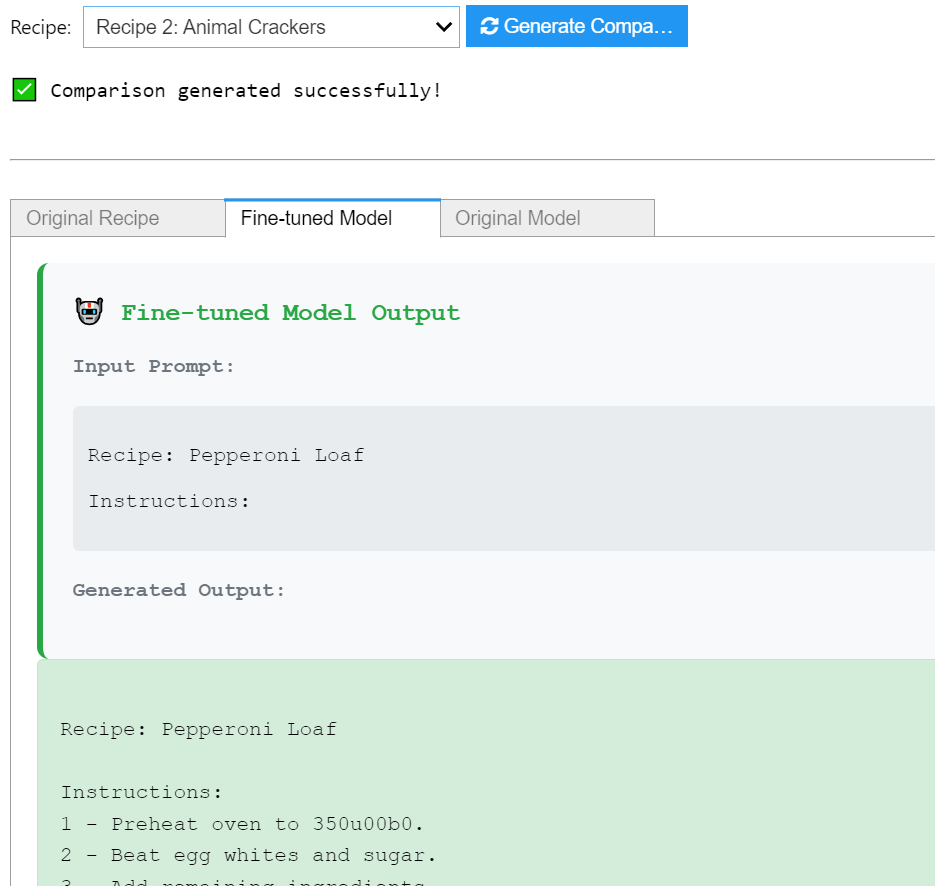